In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = ""

In [2]:
df = pd.read_csv(data_dir+"dairy_bull_data.csv")

df.head()

,breed,country_of_origin,sire_code,period,price,birth_date,pta_milk,pta_fat_lb,pta_scs,pta_protein_lb,pta_dpr
0,AY,CAN,18491,2000-02-01,12.0,1991-10-20,1124.0,41.0,3.32,32.0,NaN
1,AY,CAN,18493,2000-02-01,18.0,1992-06-15,1664.0,44.0,2.92,35.0,NaN
2,AY,CAN,18697,2000-02-01,12.0,1992-05-30,939.0,45.0,2.87,27.0,NaN
3,AY,CAN,18696,2000-02-01,12.0,1992-06-25,660.0,30.0,3.28,21.0,NaN
4,AY,CAN,18494,2000-02-01,15.0,1992-10-25,259.0,26.0,3.18,6.0,NaN


<AxesSubplot:ylabel='Frequency'>

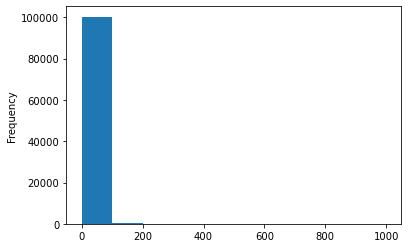

In [3]:
df['price'].plot(kind="hist")

In [4]:
df['decade'] = df['price'].apply(lambda x: str(x)[:3]) + "0"

decades = pd.get_dummies(df.decade)

decades.columns = ["decade_"+x for x in decades.columns]

df = pd.concat([df,decades],axis=1)

In [5]:
features = list(df.columns)[1:5] + list(df.iloc[:,7:379].columns) + list(df.iloc[:,381:].columns)

len(features)

95

In [6]:
features.remove("country_of_origin")
features.remove("period")
features.remove("pta_dpr")
df.replace("nan0",np.nan,inplace=True) 
df.dropna()
X = StandardScaler().fit_transform(df[features])
y = StandardScaler().fit_transform(df[['price']])


In [7]:
from sklearn.impute import SimpleImputer
sim = SimpleImputer(missing_values=np.nan, strategy='mean')
X = sim.fit_transform(X)
y = sim.fit_transform(y)
from sklearn.linear_model import Lasso

lasso_model =Lasso(alpha=.1)

lasso_model = lasso_model.fit(y=y,X=X)

In [8]:
lasso_model.coef_

array([ 0.        ,  0.83411095,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [9]:
bool_ = lasso_model.coef_!=0
print(sum(bool_))
df[features].iloc[:,bool_].columns

1


Index(['price'], dtype='object')

In [10]:
def get_coefs(alpha,features,target):
    X = StandardScaler().fit_transform(df[features])
    y = StandardScaler().fit_transform(df[target])
    sim = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = sim.fit_transform(X)
    y = sim.fit_transform(y)
    lasso_model =Lasso(alpha=alpha)
    lasso_model = lasso_model.fit(y=y,X=X)
    
    coefs = lasso_model.coef_
    
    return coefs

Alpha = np.arange(0,1,.01)

coef_lists = [list(get_coefs(a,df[features].iloc[:,bool_].columns,["price"])) for a in Alpha]


C:\Users\fxx\AppData\Local\Temp\ipykernel_10816\391069845.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model = lasso_model.fit(y=y,X=X)
D:\anaconda\ana\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


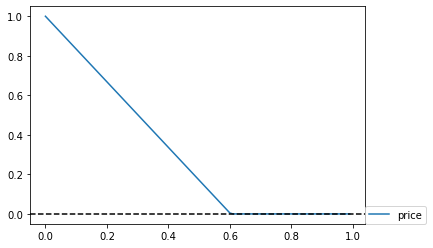

In [11]:
Coefs = pd.DataFrame(coef_lists)

Coefs.columns = df[features].iloc[:,bool_].columns
Coefs.index=Alpha

Coefs.plot(cmap="tab20")
plt.legend(loc=(1,0))
plt.axhline(0,ls="--",color="black")

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = Lasso(alpha=.05).fit(X_train,y_train)

y_hat = model.predict(X_test)

rmse = ((y_hat - y_test[:,0])**2).mean()
print("alpha = .05, RMSE =" + str(rmse)) 

model = Lasso(alpha=.15).fit(X_train,y_train)

y_hat = model.predict(X_test)

rmse = ((y_hat - y_test[:,0])**2).mean()
print("alpha = .15, RMSE =" + str(rmse)) 

alpha = .05, RMSE =0.0062463850900177096
alpha = .15, RMSE =0.056217465810155125


In [13]:
def get_alpha_rmse(alpha):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = Lasso(alpha=alpha).fit(X_train,y_train)

    y_hat = model.predict(X_test)

    rmse = ((y_hat - y_test[:,0])**2).mean()
    return rmse 

In [16]:
A = np.arange(.0001,1,.001)

rmses = [get_alpha_rmse(a) for a in A]

In [ ]:
plt.plot(A,rmses)

In [17]:
from sklearn.linear_model import LassoCV

Alpha = np.arange(0,1,.005)
lasso_model = LassoCV(alphas=A,cv=10)

lasso_model = lasso_model.fit(X,y)

D:\anaconda\ana\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
#(lasso_model.coef_!=0).sum(),  lasso_model.alpha_

In [18]:
model = ElasticNet(alpha=.5,l1_ratio=.5)
model = model.fit(X,y)
model.coef_

array([ 0.        ,  0.37318389,  0.        , -0.        ,  0.        ,
        0.06995721, -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [ ]:
param_grid ={"alpha":np.arange(0,1.1,.025),"l1_ratio":np.arange(0,1.1,.1)}
model = GridSearchCV(ElasticNet(),param_grid,n_jobs=6) # Notice I can parallelize it!
from sklearn import linear_model
model = linear_model.LinearRegression()

model = model.fit(X,y)

In [20]:
model.best_estimator_

In [22]:
best_coefs = model.best_estimator_.coef_

In [ ]:
(best_coefs!=0).sum()

In [23]:
((y[:,0] - model.predict(X))**2).sum()**.5

181.15595404065942

In [24]:
test = pd.read_csv(data_dir+"dairy_bull_data.csv")

test['decade'] = test['price'].apply(lambda x: str(x)[:3]) + "0"

decades = pd.get_dummies(test.decade)

decades.columns = ["decade_"+x for x in decades.columns]

test = pd.concat([test,decades],axis=1)

In [25]:
test.replace("nan0",np.nan,inplace=True) 
test.dropna()
X_test = StandardScaler().fit_transform(test[features])

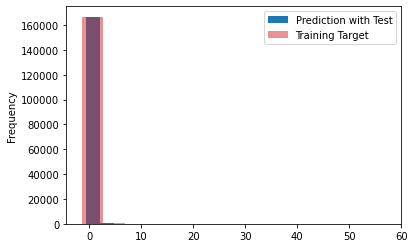

In [26]:
sim = SimpleImputer(missing_values=np.nan, strategy='mean')
pd.Series(model.predict(sim.fit_transform(X_test))).plot(kind="hist",label="Prediction with Test")
pd.Series(y[:,0]).plot(kind="hist",color="C3",alpha=.5,bins=14,label="Training Target")
plt.legend()

In [27]:
features = ['breed', 'country_of_origin', 'sire_code', 'period', 'price',
               'birth_date', 'pta_milk', 'pta_fat_lb', 'pta_scs',
               'pta_protein_lb', 'pta_dpr']

In [28]:
features.remove("breed")
features.remove("country_of_origin")
features.remove("period")
features.remove("pta_dpr")
features.remove("birth_date")
X = sim.fit_transform(StandardScaler().fit_transform(df[features]))

y = sim.fit_transform(StandardScaler().fit_transform(df[['price']]))

In [29]:
number_trees = np.arange(200,2000,20)
max_depth = np.arange(10,110,10)
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': number_trees,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': [True,False]}

In [30]:
rf_random = RandomForestRegressor()

In [31]:
#rf_random = RandomizedSearchCV(rf,random_grid,n_iter=20,n_jobs=-1,random_state=40)

rf_random.fit(X,y)

C:\Users\fxx\AppData\Local\Temp\ipykernel_10816\4050202291.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_random.fit(X,y)


RandomForestRegressor()

In [33]:
rf_random.best_params_

In [34]:
df['pta_milk'] = rf_random.predict(X)

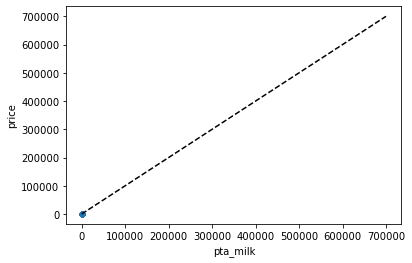

In [35]:
df[['price','pta_milk']].plot(kind='scatter',y="price",x='pta_milk',alpha=.35)
plt.plot(np.linspace(0,700000,10),np.linspace(0,700000,10),color="black",ls="--")

In [36]:
((df['price']-df['pta_milk'])**2).mean()**.5

29.243328387419457

In [37]:
X_test = test[features].values

In [39]:
test['sale_price_pred'] = rf_random.predict(sim.fit_transform(X_test))

<AxesSubplot:ylabel='Frequency'>

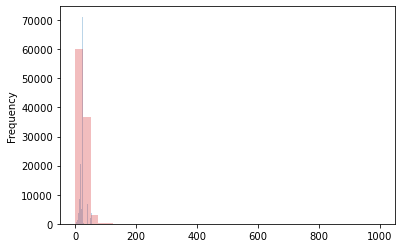

In [44]:
test.sale_price_pred.plot(kind="hist",bins=30,alpha=.3)
df['price'].plot(kind="hist",bins=40,color='C3',alpha=.3)

In [45]:
test[['sale_price_pred']].to_csv("rv-prices.csv",index=False)

In [47]:
normalizer = preprocessing.Normalization()

normalizer.adapt(X)

In [48]:
def build_and_compile_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) # Notice this one only has one neuron, so it is the output layer.
              ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [49]:
model = build_and_compile_model(normalizer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 6)                13        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [53]:
runs = model.fit(X,y,validation_split=0.2,
                    verbose=0, epochs=1000)

In [ ]:
plt.plot(runs.history['loss'])

In [52]:
df['y_hat_dnn'] = model.predict(X)

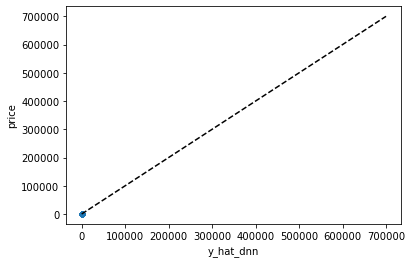

In [54]:
df[['price','y_hat_dnn']].plot(kind='scatter',y="price",x='y_hat_dnn',alpha=.35)
plt.plot(np.linspace(0,700000,10),np.linspace(0,700000,10),color="black",ls="--")

In [55]:
((df['price']-df['y_hat_dnn'])**2).mean()**.5

29.24221499293567

In [56]:
test['dnn_pred'] = model.predict(X_test)

<AxesSubplot:ylabel='Frequency'>

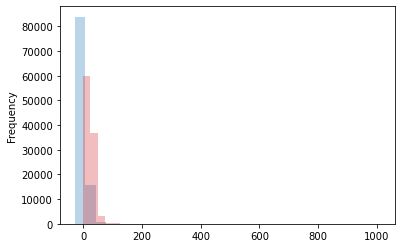

In [58]:
test.dnn_pred.plot(kind="hist",bins=30,alpha=.3)
df['price'].plot(kind="hist",bins=40,color='C3',alpha=.3)